In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Размер под ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

num_classes = 10  # CIFAR-10 имеет 10 классов
classes = trainset.classes

100%|██████████| 170M/170M [00:04<00:00, 35.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Загружаем предобученную ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)  # Меняем последний слой

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


In [ ]:
# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
# 6. Обучаем модель
num_epochs = 10
train_losses, train_accs, test_losses, test_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_losses.append(running_loss / len(trainloader))
    train_accs.append(train_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Acc: {train_acc:.2f}%")

Epoch 1/10, Loss: 518.6977, Acc: 88.88%
Epoch 2/10, Loss: 197.1583, Acc: 95.81%
Epoch 3/10, Loss: 118.0673, Acc: 97.56%
Epoch 4/10, Loss: 87.3236, Acc: 98.20%
Epoch 5/10, Loss: 71.5215, Acc: 98.48%
Epoch 6/10, Loss: 63.8254, Acc: 98.67%
Epoch 7/10, Loss: 52.4064, Acc: 98.84%
Epoch 8/10, Loss: 54.0339, Acc: 98.86%
Epoch 9/10, Loss: 43.4241, Acc: 99.05%
Epoch 10/10, Loss: 41.6855, Acc: 99.12%


In [ ]:
# Тестируем модель
model.eval()
correct, total = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Final Test Accuracy: {test_acc:.2f}%")

Final Test Accuracy: 94.21%


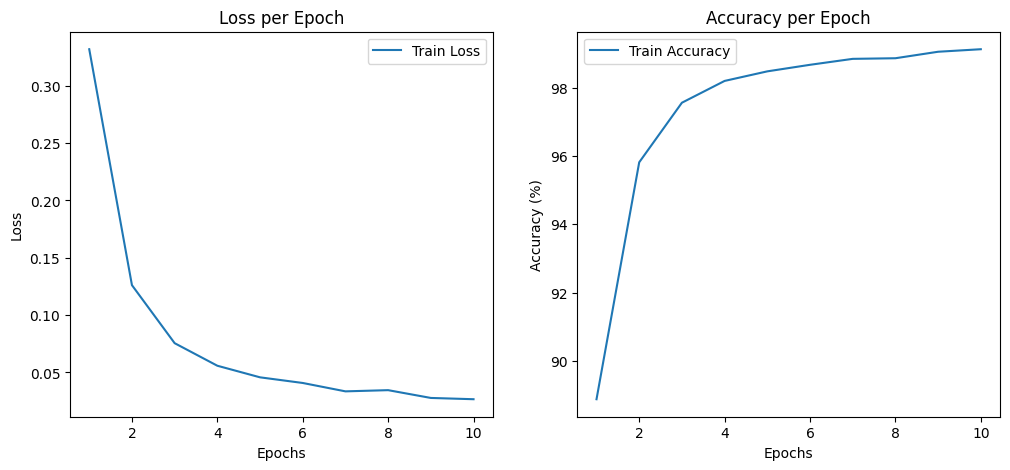

In [ ]:
# Графики потерь и точности
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy per Epoch')

plt.show()

Classification Report:
              precision    recall  f1-score   support

    airplane       0.95      0.96      0.95      1000
  automobile       0.95      0.98      0.97      1000
        bird       0.95      0.92      0.93      1000
         cat       0.92      0.83      0.87      1000
        deer       0.94      0.96      0.95      1000
         dog       0.86      0.93      0.90      1000
        frog       0.96      0.96      0.96      1000
       horse       0.97      0.96      0.96      1000
        ship       0.97      0.96      0.96      1000
       truck       0.96      0.96      0.96      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



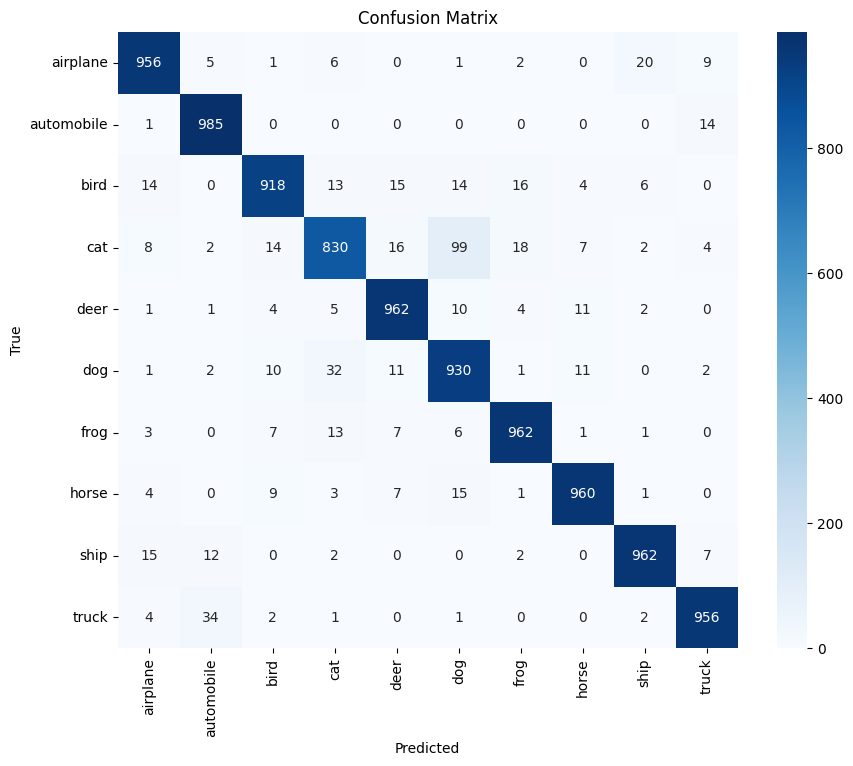

In [ ]:
# Classification Report & Confusion Matrix
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()